In [0]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)
import tqdm

Sigmoid neurons

In [0]:
d = 50 # dimension of space
M = 10 # number of neurons for generation

In [0]:
def sigma(x):
    return (1. / (1. + np.exp(-x)))

In [0]:
class Neuron:
    def __init__(self):
        self.a = np.random.normal(loc = 0., scale = 1.) # 2. et 10.
        self.w = np.random.normal(size = d, loc = 0., scale = 1.)
        self.b = np.random.normal(loc = 0., scale = 1.)
    def set_weights(self, a, w, b):
        self.a = a
        self.w = w
        self.b = b
    def forward(self, x):
        return self.a * sigma(self.w.dot(x) + self.b)

In [0]:
class Network:
    def __init__(self, width):
        self.width = width
        self.neurons = [Neuron() for i in range(width)]
    def zero_out(self):
        for nr in self.neurons:
            nr.set_weights(0., nr.w, nr.b)
    def zero_bias(self):
        for nr in self.neurons:
            nr.set_weights(nr.a, nr.w, 0)
    def norm_weights(self):
        for nr in self.neurons:
            norm = abs(nr.a) * np.sqrt(np.linalg.norm(nr.w, 2)**2 + nr.b**2)
            nr.set_weights(nr.a/norm, nr.w/norm, nr.b/norm)
    def output(self, x):
        return np.mean([n.forward(x) for n in self.neurons])
    def loss(self, x, y):
        return .5*(self.output(x) - y)**2
    def grad(self, x, y):
        d = (self.output(x) - y)
        s = np.array([sigma(n.w.dot(x) + n.b) for n in self.neurons])
        ga = 1./self.width * d * s
        gb = 1./self.width * d * np.array([self.neurons[i].a*s[i]*(1-s[i]) for i in range(self.width)])
        gw = np.array([gb[i] * x for i in range(self.width)]) # shape m * d
        return ga, gw, gb
    def step(self, x, y, tau):
        ga, gw, gb = self.grad(x, y)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def batch_step(self, X, Y, tau):
        ba = X.shape[0]
        Ga, Gw, Gb = np.zeros((ba, self.width)), np.zeros((ba, self.width, d)), np.zeros((ba, self.width))
        for i in range(ba):
            Ga[i], Gw[i], Gb[i] = self.grad(X[i], Y[i])
        ga, gw, gb = Ga.sum(axis = 0), Gw.sum(axis = 0), Gb.sum(axis = 0)
        for i in range(self.width):
            nr = self.neurons[i]
            a_new = nr.a - tau * ga[i]
            w_new = nr.w - tau * gw[i]
            b_new = nr.b - tau * gb[i]
            nr.set_weights(a_new, w_new, b_new)
    def sgd_train(self, X, Y, tau, epochs, batch, disp = True):
        for e in range(epochs):
            pm = np.random.permutation(X.shape[0])
            X = np.array([X[pm[i]] for i in range(X.shape[0])])
            Y = np.array([Y[pm[i]] for i in range(Y.shape[0])])
            if batch > 1:
                nbatch = X.shape[0]//batch
                subX = np.split(X, nbatch)
                subY = np.split(Y, nbatch)
                for s in range(len(subX)):
                    self.batch_step(subX[s], subY[s], tau)
            else:
                for i in range(X.shape[0]):
                    self.step(X[i], Y[i], tau)
            loss = self.test(X, Y)
            if disp:
                print('epoch '+str(e)+' : '+str(loss))
        return loss
    def test(self, X_t, Y_t):
        ts = X_t.shape[0]
        return np.mean([self.loss(X_t[i], Y_t[i]) for i in range(ts)])
    def gen_sample(self, R, s = 1):
        if s==1:
            X = np.random.normal(size = d)
            # see one which one it should be
            #X = R * X / np.linalg.norm(X, 2)
            X = R * X / np.sqrt(1. + np.linalg.norm(X, 2)**2)
            Y = self.output(X)
            return X, Y
        else:
            X = np.random.normal(size = (s, d))
            Y = np.zeros(s)
            for i in range(s):
                # see one which one it should be
                X[i] = R * X[i] / np.sqrt(1. + np.linalg.norm(X[i], 2)**2)
                #X[i] = R* X[i] / np.linalg.norm(X[i], 2)
                Y[i] = self.output(X[i])
            return X, Y
    def give_weights(self):
        la, lw, lb = np.zeros(self.width), np.zeros((self.width, d)), np.zeros(self.width)
        for i in range(self.width):
            nr = self.neurons[i]
            la[i] = nr.a
            lw[i] = nr.w
            lb[i] = nr.b
        return la, lw, lb
    def display_weights(self, fig, ax, scatp = None, scatn = None, true_w = None, color='b'):
        assert d==2, 'must be in dimension 2'
        #ax.cla()
        ax.set_xlim((-3, 3))
        ax.set_ylim((-3, 3))
        la, lw, _ = self.give_weights()
        xp, yp, sp, xn, yn, sn = [],[],[],[],[],[]
        la = la / np.linalg.norm(la, 2)
        for k in range(self.width):
            if la[k] >=0:
                xp.append(lw[k, 0])
                yp.append(lw[k, 1])
                sp.append(500 * la[k])
            else:
                xn.append(lw[k, 0])
                yn.append(lw[k, 1])
                sn.append(-500 * la[k])
                
        if scatp is None:
            pos = ax.scatter(xp, yp, s = sp, color='r')
        else:
            scatp.set_sizes(30*sp)
            scatp.set_offsets(np.array([xp, yp]).T)
            trace = ax.scatter(xp, yp, s = 5., color='grey', alpha = 0.4)
            
        if scatn is None:
            neg = ax.scatter(xn, yn, s = sn, color='b')
        else:
            scatn.set_sizes(30*sn)
            scatn.set_offsets(np.array([xn, yn]).T)
            trace = ax.scatter(xn, yn, s = 5., color='grey', alpha = 0.4)
        
        if true_w is not None:
            tla, tlw, _ = true_w
            tx, ty = np.zeros(tla.shape[0]), np.zeros(tla.shape[0])
            for k in range(tla.shape[0]):
                tx[k] = tlw[k, 0]
                ty[k] = tlw[k, 1]
                u = np.linspace(-3, 3., 10)
                v = ty[k]/tx[k] * u
                ax.plot(u, v, color = 'k')
        
        if scatp is None and scatn is None:
            fig.canvas.draw()
        #del pos
        #del neg
        return xp, yp, xn, yn

In [0]:
#fig, ax = plt.subplots(figsize=(10, 6))

gen_net = Network(M)
#gen_net.norm_weights()
true_w = gen_net.give_weights()
print(true_w[2])
#xp, yp, xn, yn = gen_net.display_weights(fig, ax, color='g', true_w = true_w)
#ax.scatter(xp, yp, s = 10., color='r')
#ax.scatter(xn, yn, s = 10., color='b')

[-0.35224985  0.59357852 -0.10015523 -0.89055558 -0.6069984   0.30526704
  0.35249436 -1.77756638  1.7653351   1.10717545]


Initialize new network with first parameter 0 and others normal.

Data on the sphere

Train it using SGD

In [0]:
X_test, Y_test = gen_net.gen_sample(R = 10., s = 10000)

In [0]:
net = Network(50) # over-parametrized
net.zero_out()

test_loss = []
train_loss = []
test = net.test(X_test, Y_test)
print('init', test)
for i in range(5000):
    X, Y = gen_net.gen_sample(R = 10., s = 100)
    net.sgd_train(X, Y, tau = 20., batch = 1, epochs = 1, disp = False)
    if i%10 == 0:
        test = net.test(X_test, Y_test)
        train = net.test(X, Y)
        test_loss.append(test)
        train_loss.append(train)
        print(test)

init 0.009855086468709038
0.008850957803446758
0.004495394779670694
0.0035146335004736856
0.0034028041490401064
0.003432694312796669
0.003264391399801154
0.0031436511183142875
0.003286931661143059
0.003065852931090582
0.003042534808208148
0.003138770822383894
0.0030849927156613183
0.00290928198899116
0.003060343377601718
0.0034746551319278706
0.0032200952057975882
0.00262419426599383
0.002496419273932068
0.002158686108462875
0.001986874670380212
0.0019095921467824194
0.0016706199292658088
0.0018424318613436534
0.0016062472870023235
0.0016486409095369822
0.0014261857194889302
0.0013780366071214495
0.0012824342414404044
0.001577294784728585
0.0012952661291673862
0.0010960173603177
0.0010891930403984851
0.0009465685814224365
0.0008385628875044929
0.00079352390484728
0.0007461549436423867
0.0007039806429438855
0.0006367058462394076
0.0005563993874934976
0.0005636504944785744
0.0005858533836890691
0.0005414591797023583
0.000498690986027208
0.000501908944449994
0.0005288205260911452
0.000414

KeyboardInterrupt: ignored

Text(0.5,1,'Training a neural network with 50 units (M = 20)')

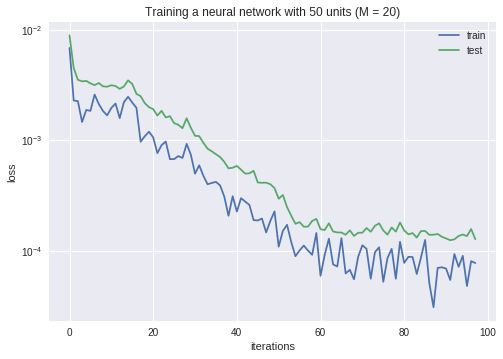

In [0]:
plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train', 'test'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Training a neural network with 50 units (M = 20)')

In [0]:
net = Network(3) # under-parametrized
net.zero_out()

test_loss = []
train_loss = []
test = net.test(X_test, Y_test)
print('init', test)
for i in range(5000):
    X, Y = gen_net.gen_sample(R = 10., s = 100)
    net.sgd_train(X, Y, tau = 1., batch = 1, epochs = 1, disp = False)
    if i%10 == 0:
        test = net.test(X_test, Y_test)
        train = net.test(X, Y)
        test_loss.append(test)
        train_loss.append(train)
        print(test)

init 0.009855086468709038
0.00933820771382467
0.009233440359468294
0.009362149735740137
0.009301043018634917
0.010010774066897512
0.00875220840987719
0.009518316404565724
0.008637948838778808
0.0077006568792675235
0.008707388169298318
0.007041799647172075
0.006758005957407795
0.005977502954198316
0.006623576375366919
0.00546098966227527
0.005358205694247586
0.00557853418989707
0.004864854636090299
0.004930023229021776
0.004792915307244154
0.004743090176988126
0.008111323427545515
0.004494030528987906
0.005034060630747365
0.005653092892018809
0.00488756503217771
0.0044371603431477506
0.005086640909856644
0.005158283745806792
0.004758429953779039
0.004515267583114475
0.0042862486428180135
0.004567806964680655
0.004796841973618274
0.004394099976597741
0.004173174334089305
0.004271456027263127
0.004354161587958067
0.004083991611514496
0.004381822915209501
0.004352318610590976
0.004694122784717049
0.00446371838651652
0.004011641758894245
0.003988542613094222
0.004107547264380261
0.004082919

Text(0.5,1,'Training a neural network with 3 units (M = 20)')

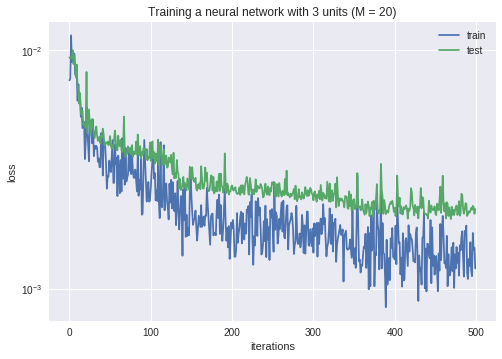

In [0]:
plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train', 'test'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Training a neural network with 3 units (M = 20)')

In [0]:
net = Network(15) # sehr ober-parametrized
net.zero_out()

test_loss = []
train_loss = []
test = net.test(X_test, Y_test)
print('init', test)
for i in range(5000):
    X, Y = gen_net.gen_sample(R = 10., s = 100)
    net.sgd_train(X, Y, tau = 30., batch = 1, epochs = 1, disp = False)
    if i%10 == 0:
        test = net.test(X_test, Y_test)
        train = net.test(X, Y)
        test_loss.append(test)
        train_loss.append(train)
        print(test)

init 0.009855086468709038
0.013570710767665384
0.005636733924428313
0.005999235248163712
0.007030017546798914
0.005645456763155606
0.005522376953546413
0.007859732895032025
0.0055778768051806165
0.003947109955139092
0.004778970486994987
0.005962841143448472
0.004801469459293695
0.004712092885552629
0.004927266334457209
0.0037810693358295666
0.005549680062645254
0.004907851423154258
0.0035993888027945472
0.005032334520811627
0.003789266504069638
0.005791728403024049
0.005095070259049857
0.007101943699986441
0.0036169088296328852
0.005336657058344174
0.0044346298971945225
0.006293761757345176
0.004250693223847638
0.003959997050985448
0.004011884990245216
0.006140479490544642
0.003411849414436177
0.0032437745998086577
0.003277932391722328
0.0033502451357266374
0.005462438206580404
0.0034138346315269997
0.0038600836538793502
0.00365527725815473
0.003718739459977227
0.0033492214902480144
0.006588677813553661
0.003991391168671643
0.005256855559300537
0.003584441175478407
0.003435295941264907

Text(0.5,1,'Training a neural network with 100 units (M = 20)')

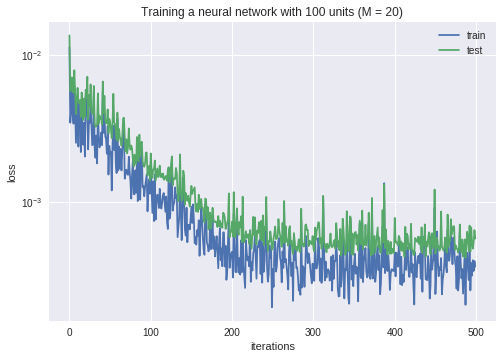

In [0]:
plt.figure()
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train', 'test'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Training a neural network with 100 units (M = 20)')

Lag train test pas présent pour le cas underparametrized

Learning rate: lr ~ nbr of neurons

We DO NOT reproduce the results :(

## Make several experiments for different values of $m$

In [0]:
np.logspace(.5, 1.7, 10, base = 10.)

array([ 3.16227766,  4.29866235,  5.84341413,  7.94328235, 10.79775162,
       14.67799268, 19.95262315, 27.12272579, 36.86945065, 50.11872336])

Early stopping if no improvement for k rounds -> def train_to_opt to ensure convergence

In [0]:
m_range = np.logspace(.5, 1.7, 10, base = 10.)
m_range = [int(b) for b in m_range]
rep = 5
losses = np.zeros((len(m_range), rep))

for r in tqdm.tqdm(range(rep)):
    gen_net = Network(M)
    Xt, Yt = gen_net.gen_sample(R = 10., s = 10000)
    for mi in range(len(m_range)-2):
        m = m_range[mi]
        net = Network(m)
        net.zero_out()
        X, Y = gen_net.gen_sample(R = 10., s = 1000000)
        train_loss = net.sgd_train(X, Y, tau = .3*m, batch = 1, epochs = 1, disp = False)
        print('train', train_loss)
        losses[mi, r] = net.test(Xt, Yt)
        print('test', losses[mi, r])
        net = []
        print(m)


  0%|          | 0/5 [00:00<?, ?it/s]

train 0.002674697610053854
test 0.0026975931676284045
3
train 0.0011120100111180488
test 0.001093773288463524
4
train 0.000731164563707832
test 0.0007324793353405449
5
train 0.0001327219797968409
test 0.0001284798646887931
7
train 3.883923642184509e-06
test 3.922463645653602e-06
10
train 2.6691637777343234e-06
test 2.675417019961901e-06
14
train 3.7772889999366116e-06
test 3.820876864798793e-06
19
train 6.6256641619634354e-06



 20%|██        | 1/5 [35:31<2:22:04, 2131.13s/it]

test 6.5023291843396945e-06
27
train 0.0008482171732595172
test 0.000852632732954624
3
train 0.0006822590784088274
test 0.000688562630091502
4
train 0.00029962894436832136
test 0.00030239322262368324
5
train 0.0001897098478456146
test 0.000188127411877775
7
train 0.00010089377373242921
test 0.00010173104829775586
10
train 5.6359075586543975e-05
test 5.654091380625561e-05
14
train 1.4256401632403932e-05
test 1.4095935715439944e-05
19
train 1.7984155675398038e-05



 40%|████      | 2/5 [1:10:49<1:46:21, 2127.30s/it]

test 1.7650420655895027e-05
27
train 0.001027383153985497
test 0.0010418488022521345
3
train 0.0008446550839686445
test 0.0008306833000790526
4
train 0.00037844082750063894
test 0.00037619136545377266
5
train 0.0001675747451571191
test 0.00016523424393718634
7
train 9.910999984498879e-05
test 9.5763997468494e-05
10
train 2.6517381447354826e-05
test 2.6563210248195735e-05
14
train 1.6124566518133268e-05
test 1.6137283803993864e-05
19
train 4.564974267159581e-06



 60%|██████    | 3/5 [1:46:11<1:10:51, 2125.84s/it]

test 4.5020556547145815e-06
27
train 0.003623499576264531
test 0.003658026875055543
3
train 0.001698013048454984
test 0.0017373571594888524
4
train 0.0007968750053855526
test 0.000810938347472964
5
train 0.00014043869931179293
test 0.00013833107782515634
7
train 2.8858215863037596e-05
test 2.912240335592954e-05
10
train 1.775815990361077e-05
test 1.7894984290740566e-05
14
train 4.4774482758158104e-05
test 4.533477704830907e-05
19
train 3.3522463163646015e-05



 80%|████████  | 4/5 [2:21:35<35:25, 2125.02s/it]  

test 3.3687893445589414e-05
27
train 0.000497010327422277
test 0.0005052137657888323
3
train 0.00021991599175844568
test 0.0002181698687543599
4
train 0.00016085355442338237
test 0.00016451910643911546
5
train 9.838029103638358e-05
test 0.00010011538515903172
7
train 5.696226784520516e-05
test 5.648894477215345e-05
10
train 1.2365344801164753e-05
test 1.213167680065135e-05
14
train 1.4406352771278483e-05
test 1.4073400684554686e-05
19
train 1.3967825090623315e-05



100%|██████████| 5/5 [2:56:58<00:00, 2124.44s/it]


test 1.3435245347515746e-05
27


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


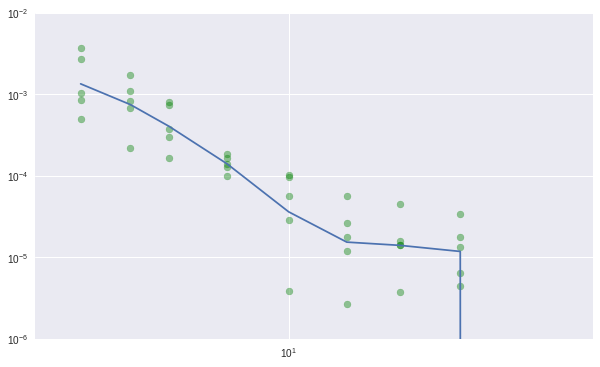

In [0]:
plt.figure(figsize = (10, 6))
for i in range(rep):
    plt.scatter(m_range, losses[:, i], c='g', alpha = 0.4)
plt.plot(m_range, np.exp(np.mean(np.log(losses), axis = 1)))
plt.yscale('log')
plt.xscale('log')
#plt.xlim((2.8, 105))
plt.ylim((1e-6, 1e-2))
plt.show()

In [0]:
m_range

[3, 4, 5, 7, 10, 14, 19, 27, 36, 50]

In [0]:
losses

array([[2.69759317e-03, 8.52632733e-04, 1.04184880e-03, 3.65802688e-03,
        5.05213766e-04],
       [1.09377329e-03, 6.88562630e-04, 8.30683300e-04, 1.73735716e-03,
        2.18169869e-04],
       [7.32479335e-04, 3.02393223e-04, 3.76191365e-04, 8.10938347e-04,
        1.64519106e-04],
       [1.28479865e-04, 1.88127412e-04, 1.65234244e-04, 1.38331078e-04,
        1.00115385e-04],
       [3.92246365e-06, 1.01731048e-04, 9.57639975e-05, 2.91224034e-05,
        5.64889448e-05],
       [2.67541702e-06, 5.65409138e-05, 2.65632102e-05, 1.78949843e-05,
        1.21316768e-05],
       [3.82087686e-06, 1.40959357e-05, 1.61372838e-05, 4.53347770e-05,
        1.40734007e-05],
       [6.50232918e-06, 1.76504207e-05, 4.50205565e-06, 3.36878934e-05,
        1.34352453e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

Write batch train function, reduce d, "use fresh samples at each iteration", sampling at test time

In [0]:
losses = np.array([[2.69759317e-03, 8.52632733e-04, 1.04184880e-03, 3.65802688e-03,
        5.05213766e-04],
       [1.09377329e-03, 6.88562630e-04, 8.30683300e-04, 1.73735716e-03,
        2.18169869e-04],
       [7.32479335e-04, 3.02393223e-04, 3.76191365e-04, 8.10938347e-04,
        1.64519106e-04],
       [1.28479865e-04, 1.88127412e-04, 1.65234244e-04, 1.38331078e-04,
        1.00115385e-04],
       [3.92246365e-06, 1.01731048e-04, 9.57639975e-05, 2.91224034e-05,
        5.64889448e-05],
       [2.67541702e-06, 5.65409138e-05, 2.65632102e-05, 1.78949843e-05,
        1.21316768e-05],
       [3.82087686e-06, 1.40959357e-05, 1.61372838e-05, 4.53347770e-05,
        1.40734007e-05],
       [6.50232918e-06, 1.76504207e-05, 4.50205565e-06, 3.36878934e-05,
        1.34352453e-05]])

m_range = [3, 4, 5, 7, 10, 14, 19, 27]

rep = 5

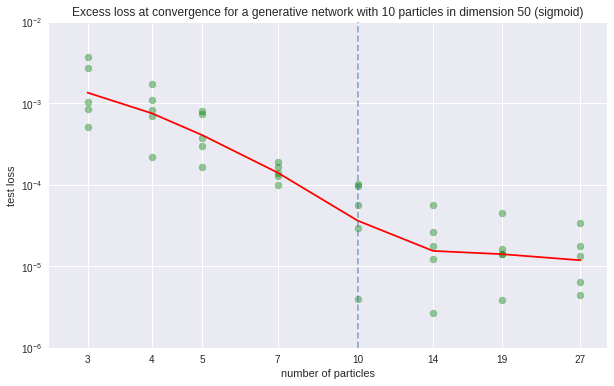

In [0]:
plt.figure(figsize = (10, 6))
for i in range(rep):
    plt.scatter(m_range, losses[:, i], c='g', alpha = 0.4)
plt.plot(m_range, np.exp(np.mean(np.log(losses), axis = 1)), c='r')
plt.yscale('log')
plt.xscale('log')
#plt.xlim((2.8, 105))
plt.ylim((1e-6, 1e-2))
plt.xticks(m_range, m_range)
plt.ylabel('test loss')
plt.axvline(x=10, linestyle = '--', alpha = 0.6)
plt.xlabel('number of particles')
plt.title('Excess loss at convergence for a generative network with 10 particles in dimension 50 (sigmoid)')
plt.show()